In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models
%matplotlib inline
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
import warnings

In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.0
/device:GPU:0


In [3]:
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Pepsico RnD Potato Lab Dataset/Train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )

Found 769 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['Defective', 'Non-Defective']

In [7]:
len(dataset)

25

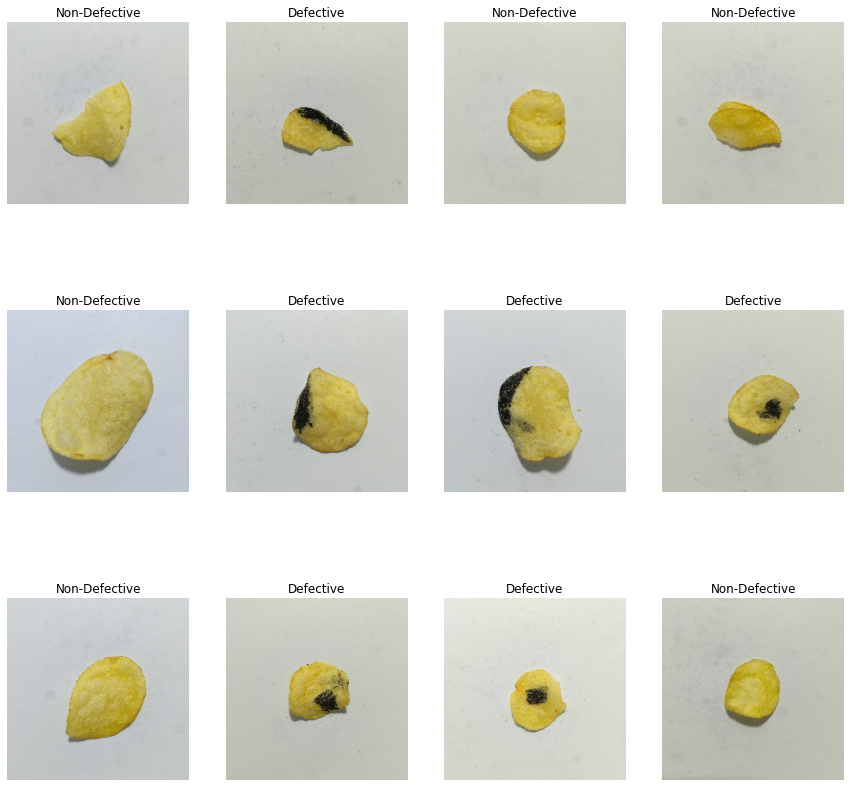

In [8]:
plt.figure(figsize = (15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split = 0.1,val_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,test_ds,val_ds

In [10]:
train_ds , test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

20

In [12]:
len(test_ds)

3

In [13]:
len(val_ds)

2

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(256,256),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (32,256,256,3)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds)

Epoch 1/50
20/20 [==============================] - 71s 201ms/step - loss: 0.7738 - accuracy: 0.4844 - val_loss: 0.6861 - val_accuracy: 0.5238
Epoch 2/50
20/20 [==============================] - 3s 175ms/step - loss: 0.6611 - accuracy: 0.5813 - val_loss: 0.4091 - val_accuracy: 0.8473
Epoch 3/50
20/20 [==============================] - 3s 174ms/step - loss: 0.4814 - accuracy: 0.8358 - val_loss: 0.1679 - val_accuracy: 0.9754
Epoch 4/50
20/20 [==============================] - 3s 175ms/step - loss: 0.2010 - accuracy: 0.9491 - val_loss: 0.2141 - val_accuracy: 0.9885
Epoch 5/50
20/20 [==============================] - 3s 175ms/step - loss: 0.1378 - accuracy: 0.9787 - val_loss: 0.1466 - val_accuracy: 0.9655
Epoch 6/50
20/20 [==============================] - 3s 175ms/step - loss: 0.0966 - accuracy: 0.9754 - val_loss: 0.0599 - val_accuracy: 0.9901
Epoch 7/50
20/20 [==============================] - 3s 175ms/step - loss: 0.1218 - accuracy: 0.9721 - val_loss: 0.0918 - val_accuracy: 0.9787
Epoch

In [21]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 1s 50ms/step - loss: 0.0397 - accuracy: 0.9934


In [22]:
scores

[0.039699986577034, 0.9934318661689758]

In [23]:
history.params

{'epochs': 50, 'steps': 20, 'verbose': 1}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

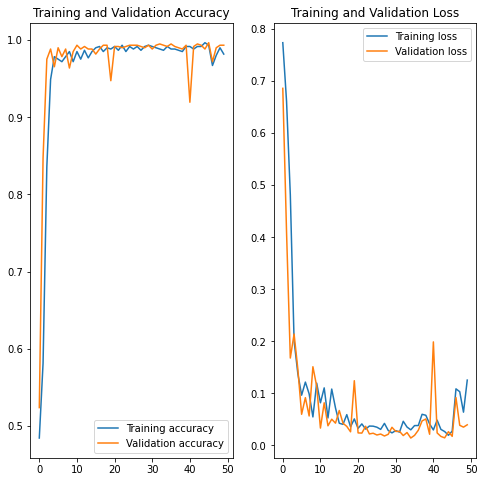

In [26]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image to Predict:
Actual Label: Defective
Predicted Label: Defective


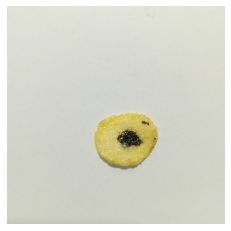

In [27]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to Predict:")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

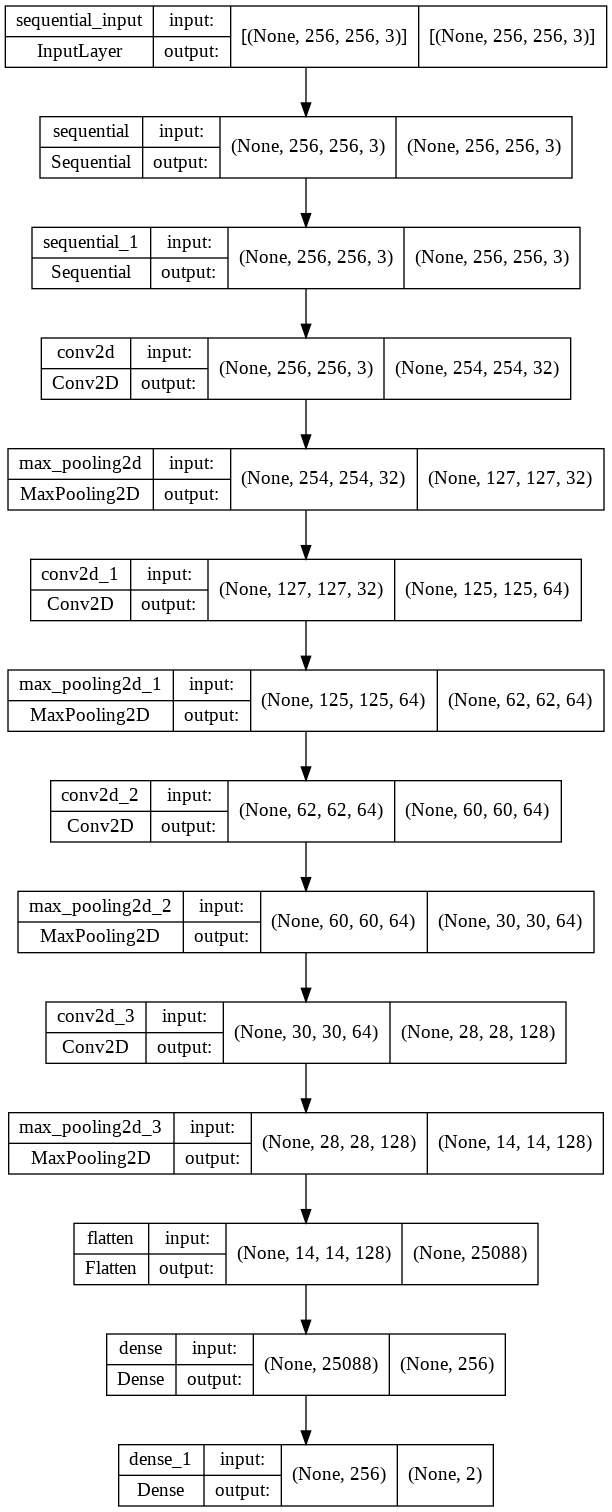

In [29]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='T', expand_nested=False, dpi=96
)

In [30]:
import os
model.save("Potato-quality.h5")